In [2]:
%run -m ipy_startup
%matplotlib inline
%load_ext rpy2.ipython
from ml import query
from pbto2 import data, prep

In [ ]:
# config_name = 'config1'
# max_hours = 48
# time = 'tsi_min'
# pbto2_thresh = 8 / max_hours
# agg_mode = 'pct'
# pbto2_bins = [0, 20, 100, np.inf]
# pao2_bins = [0, 30, 100, np.inf]
# icp_bins = [0, 20, np.inf]
# pha_bins = [0, 7.35, 7.45, np.inf]
# paco2_bins = [0, 35, 45, np.inf]
# interp = 'all'
# allow_gos_interp = True

In [ ]:
# config_name = 'config2'
# max_hours = 48
# time = 'tsi_min'
# pbto2_thresh = 8 / max_hours
# agg_mode = 'pct'
# pbto2_bins = [0, 20, 100, np.inf]
# pao2_bins = [0, 30, 100, np.inf]
# icp_bins = [0, 20, np.inf]
# pha_bins = [0, 7.35, 7.45, np.inf]
# paco2_bins = [0, 35, 45, np.inf]
# interp = 'none'
# allow_gos_interp = True

In [ ]:
# config_name = 'config3'
# max_hours = 48
# time = 'tsi_min'
# pbto2_thresh = 8 / max_hours
# agg_mode = 'pct'
# pbto2_bins = [0, 20, 70, np.inf]
# pao2_bins = [0, 300, 875, np.inf]
# icp_bins = [0, 20, np.inf]
# pha_bins = [0, 7.35, 7.45, np.inf]
# paco2_bins = [0, 28, 42, np.inf]
# interp = 'none'
# allow_gos_interp = True

In [ ]:
# config_name = 'config4'
# max_hours = 96
# time = 'tsi_min'
# pbto2_thresh = 8 / max_hours
# agg_mode = 'pct'
# pbto2_bins = [0, 20, 70, np.inf]
# pao2_bins = [0, 300, 875, np.inf]
# icp_bins = [0, 20, np.inf]
# pha_bins = [0, 7.35, 7.45, np.inf]
# paco2_bins = [0, 28, 42, np.inf]
# interp = 'none'
# allow_gos_interp = True

In [ ]:
# config_name = 'config5'
# max_hours = 24
# time = 'tsi_min'
# pbto2_thresh = 8 / max_hours
# agg_mode = 'pct'
# pbto2_bins = [0, 20, 70, np.inf]
# pao2_bins = [0, 300, 875, np.inf]
# icp_bins = [0, 20, np.inf]
# pha_bins = [0, 7.35, 7.45, np.inf]
# paco2_bins = [0, 28, 42, np.inf]
# interp = 'none'
# allow_gos_interp = True

In [ ]:
# config_name = 'config6'
# max_hours = 72
# time = 'tsi_min'
# pbto2_thresh = 8 / max_hours
# agg_mode = 'pct'
# pbto2_bins = [0, 20, 70, np.inf]
# pao2_bins = [0, 300, 875, np.inf]
# icp_bins = [0, 20, np.inf]
# pha_bins = [0, 7.35, 7.45, np.inf]
# paco2_bins = [0, 28, 42, np.inf]
# interp = 'none'
# allow_gos_interp = True

In [75]:
config_name = 'config7'
max_hours = 36
time = 'tsi_min'
pbto2_thresh = 8 / max_hours
agg_mode = 'pct'
pbto2_bins = [0, 20, 70, np.inf]
pao2_bins = [0, 300, 875, np.inf]
icp_bins = [0, 20, np.inf]
pha_bins = [0, 7.35, 7.45, np.inf]
paco2_bins = [0, 28, 42, np.inf]
interp = 'none'
allow_gos_interp = True

d = data.get_raw_data(f='data_clean_interp_{}.pkl'.format(interp))

# Divide pao2 values by constant
d['pao2'] = d['pao2'] / .4

# This patient has an excessively long string of consecutive 0 pbto2 values after this tsa_min value
# (so remove the unnecessary measurements)
d = d[(d['uid'] != 1001) | (d['tsa_min'] <= 1320)]

def plot_ts(d, col, uids, figsize=(12,6), ylim=None):
    df = d[d['uid'].isin(uids)][['tsa_min', col, 'uid']]
    ax = df.pivot_table(index='tsa_min', columns='uid', values=col).plot(figsize=figsize)
    if ylim is not None:
        ax.set_ylim(ylim)
        
# Limit to only some subset of early measurments
d = d[d[time] <= max_hours * 60]

# Remove patients that don't have enough measurments within the early subset
ct = d.groupby('uid').apply(lambda x: len(x['pbto2'].dropna()) / max_hours)
#ct.hist()
rm_uids = ct[ct < pbto2_thresh].index.values
d = d[~d['uid'].isin(rm_uids)]

# Set gos response column, using interpolation if enabled
if allow_gos_interp:
    d['gos'] = d.apply(lambda x: x['gos-3'] if not pd.isnull(x['gos-3']) else x['gos-6'], axis=1)
else:
    d['gos'] = d['gos-3']

In [76]:
#d.paco2.hist(bins=50)

In [77]:
# uids = d[d['pbto2'] <= 0].groupby('uid').size()
# uids = uids[uids > 6].index.values
# plot_ts(d, 'pbto2', uids)

In [78]:
# uids = d['uid'].unique()
# uids = uids[np.random.permutation(np.arange(len(uids)))[:10]]
# plot_ts(d, 'pao2', uids)

In [79]:
def get_features(x):
    def bin_values(v, bins, prefix, mode='count'):
        assert mode in ['count', 'mean', 'pct'], 'Mode {} is not valid'.format(mode)
        labels = ['{}_{}_{}'.format(prefix, bins[i-1], bins[i]) for i in range(1, len(bins))]
        ct = pd.cut(v, bins=bins, include_lowest=True, right=False, labels=labels)
        if mode == 'count':
            ct = ct.value_counts()
        elif mode == 'pct':
            ct = ct.value_counts()
            ct = ct if ct.sum() == 0 else ct / ct.sum()
        elif mode == 'mean':
            ct = v.groupby(ct).mean()
        ct = ct.to_dict()
        ct['{}_is_na'.format(prefix)] = 1 if len(v.dropna()) == 0 else 0
        return ct
    
    r = {}
    r.update(bin_values(x['pbto2'], pbto2_bins, 'pbto2', mode=agg_mode))
    r.update(bin_values(x['pao2'], pao2_bins, 'pao2', mode=agg_mode))
    r.update(bin_values(x['icp1'], icp_bins, 'icp1', mode=agg_mode))
    r.update(bin_values(x['pha'], pha_bins, 'pha', mode=agg_mode))
    r.update(bin_values(x['paco2'], paco2_bins, 'paco2', mode=agg_mode))
#     r['n_pbto2'] = len(x['pbto2'].dropna())
#     r['n_pao2'] = len(x['pao2'].dropna())
#     r['n_icp1'] = len(x['icp1'].dropna())
#     r['n_pha'] = len(x['pha'].dropna())
#     r['n_paco2'] = len(x['paco2'].dropna())
        
    x = x.iloc[0]
    r['gos'] = x['gos']
    r['marshall'] = x['marshall']
    r['gcs'] = x['gcs']
    r['age'] = x['age']
    r['sex'] = x['sex']
    
    return pd.Series(r)
do = d.groupby('uid').apply(get_features)
do = do[~do['gos'].isnull()]
do = do[~do['marshall'].isnull()]
do.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231 entries, 464 to 1056
Data columns (total 24 columns):
age              231 non-null float64
gcs              231 non-null float64
gos              231 non-null float64
icp1_0_20        231 non-null float64
icp1_20_inf      231 non-null float64
icp1_is_na       231 non-null float64
marshall         231 non-null float64
paco2_0_28       231 non-null float64
paco2_28_42      231 non-null float64
paco2_42_inf     231 non-null float64
paco2_is_na      231 non-null float64
pao2_0_300       231 non-null float64
pao2_300_875     231 non-null float64
pao2_875_inf     231 non-null float64
pao2_is_na       231 non-null float64
pbto2_0_20       231 non-null float64
pbto2_20_70      231 non-null float64
pbto2_70_inf     231 non-null float64
pbto2_is_na      231 non-null float64
pha_0_7.35       231 non-null float64
pha_7.35_7.45    231 non-null float64
pha_7.45_inf     231 non-null float64
pha_is_na        231 non-null float64
sex              2

# Exports

In [80]:
config = {
    'max_hours': max_hours, 'pbto2_thresh': pbto2_thresh, 'agg_mode': agg_mode,
    'ts_interp': interp, 'gos_interp': allow_gos_interp
}
export_dir = '/Users/eczech/data/pbto2/final/{}'.format(config_name)
import os
if not os.path.exists(export_dir):
    os.mkdir(export_dir)

In [81]:
# Save data in wide format
do.reset_index().to_csv('{}/data_wide.csv'.format(export_dir), index=False)

In [82]:
# Save data in long format
d_exp = d[d['uid'].isin(do.index.values)]
d_exp.to_csv('{}/data_long.csv'.format(export_dir), index=False)

In [83]:
d_exp[d_exp['pbto2'].isnull()]

,pbto2,pao2,pha,icp1,paco2,map,uid,datetime,bo2,birthdate,...,tsi,tsa,tsi_min,tsa_min,marshall,gos-12,gos-24,gos-3,gos-6,gos
23671,NaN,NaN,NaN,NaN,NaN,NaN,534,2003-08-27 11:00:00,31.4,1978-05-14,...,13:00:00,0 days,780,0,2,3,NaN,3,3,3


# Modeling

In [11]:
#do.plot(kind='scatter', x='n_pbto2', y='gos')

In [13]:
%%R -i do
library(dplyr)
library(MASS)
scale <- function(x) (x - mean(x)) / sd(x)
d <- do %>% mutate_each(funs(as.numeric)) %>%
    mutate_each(funs(scale), -gos) %>%
    #dplyr::select(-pao2_300_800, -pbto2_20_100, -starts_with('n_'), -starts_with('pao2'))
    dplyr::select(-paco2_35_45, -icp1_0_20, -pha_7.35_7.45, -pao2_30_100, -pbto2_20_100, -starts_with('n_'))

In [38]:
%%R 
res <- d %>% mutate(gos = ifelse(gos <= 3, 0, 1)) %>%
    #glm(gos ~ ., data=., family='binomial')
    glm(gos ~ age + sex + marshall + gcs + pbto2_0_20 + pao2_0_30 + pbto2_100_inf + pao2_100_inf, data=., family='binomial')
    #glm(gos ~ age + sex + marshall + gcs + icp1_20_inf, data=., family='binomial')
    #glm(gos ~ age + sex + marshall + gcs + pao2_0_30, data=., family='binomial')
    #glm(gos ~ age + sex + marshall + gcs + paco2_45_inf, data=., family='binomial')
summary(res)


Call:
glm(formula = gos ~ age + sex + marshall + gcs + pbto2_0_20 + 
    pao2_0_30 + pbto2_100_inf + pao2_100_inf, family = "binomial", 
    data = .)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5199  -0.7988  -0.4999   0.8342   2.6860  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -1.4029     0.1894  -7.409 1.28e-13 ***
age            -0.5892     0.1867  -3.156   0.0016 ** 
sex             0.1695     0.1651   1.026   0.3047    
marshall       -0.3556     0.1909  -1.863   0.0625 .  
gcs             0.4450     0.1788   2.489   0.0128 *  
pbto2_0_20     -0.4038     0.1793  -2.252   0.0243 *  
pao2_0_30      -0.4103     0.1983  -2.069   0.0385 *  
pbto2_100_inf  -0.7165     0.4738  -1.512   0.1304    
pao2_100_inf   -0.2191     0.1752  -1.251   0.2111    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 298.50  on 262  degrees 

In [26]:
%%R
get.polr.coefs <- function(m){
    coefs <- coef(summary(m))
    p <- pnorm(abs(coefs[, "t value"]), lower.tail = FALSE) * 2
    coefs <- cbind(coefs, "p value" = p)
    coefs
}
m <- d %>% 
    mutate(gos=factor(gos, levels=1:5, labels=c('Dead', 'Bad1', 'Bad2', 'Good1', 'Good2'))) %>%
    #polr(gos ~ ., data = ., Hess=TRUE)
    polr(gos ~ age + sex + marshall + gcs + pbto2_0_20 + pbto2_100_inf + pao2_0_30, data=., Hess=T)
print(summary(m))
get.polr.coefs(m)

Call:
polr(formula = gos ~ age + sex + marshall + gcs + pbto2_0_20 + 
    pbto2_100_inf + pao2_0_30, data = ., Hess = T)

Coefficients:
                 Value Std. Error t value
age           -0.83941     0.1401 -5.9935
sex            0.16232     0.1204  1.3481
marshall      -0.30964     0.1368 -2.2630
gcs            0.62843     0.1302  4.8282
pbto2_0_20    -0.28603     0.1225 -2.3346
pbto2_100_inf -0.09902     0.1130 -0.8764
pao2_0_30     -0.17431     0.1174 -1.4841

Intercepts:
            Value   Std. Error t value
Dead|Bad1   -1.3014  0.1638    -7.9443
Bad1|Bad2   -0.9939  0.1546    -6.4284
Bad2|Good1   1.4540  0.1665     8.7346
Good1|Good2  3.4610  0.2976    11.6300

Residual Deviance: 608.7859 
AIC: 630.7859 
                    Value Std. Error    t value      p value
age           -0.83940810  0.1400540 -5.9934599 2.054229e-09
sex            0.16231688  0.1204062  1.3480773 1.776335e-01
marshall      -0.30964035  0.1368259 -2.2630244 2.363419e-02
gcs            0.62843099  0.13

In [34]:
%%R
m <- d %>% 
    mutate(gos=ifelse(gos==1, 0, ifelse(gos <= 3, 1, 2))) %>%
    mutate(gos=factor(gos, levels=1:3, labels=c('Dead', 'Bad', 'Good'))) %>%
    #polr(gos ~ ., data = ., Hess=TRUE)
    polr(gos ~ age + sex + marshall + gcs + pbto2_0_20 + pbto2_100_inf + pao2_0_30, data=., Hess=T)
print(summary(m))
get.polr.coefs(m)

Call:
polr(formula = gos ~ age + sex + marshall + gcs + pbto2_100_inf, 
    data = ., Hess = T)

Coefficients:
                Value Std. Error t value
age           -0.2288     0.1964 -1.1651
sex            0.1127     0.1650  0.6832
marshall      -0.2838     0.1860 -1.5259
gcs            0.2742     0.1736  1.5797
pbto2_100_inf -0.5811     0.4464 -1.3016

Intercepts:
         Value   Std. Error t value
Dead|Bad  0.8671  0.1854     4.6778
Bad|Good 13.7204 61.0817     0.2246

Residual Deviance: 239.5522 
AIC: 253.5522 
(68 observations deleted due to missingness)
                   Value Std. Error    t value      p value
age           -0.2287880  0.1963687 -1.1650942 2.439809e-01
sex            0.1127001  0.1649707  0.6831527 4.945104e-01
marshall      -0.2838243  0.1859992 -1.5259433 1.270240e-01
gcs            0.2741758  0.1735586  1.5797307 1.141685e-01
pbto2_100_inf -0.5810889  0.4464319 -1.3016294 1.930431e-01
Dead|Bad       0.8671314  0.1853714  4.6778062 2.899604e-06
Bad|Good    

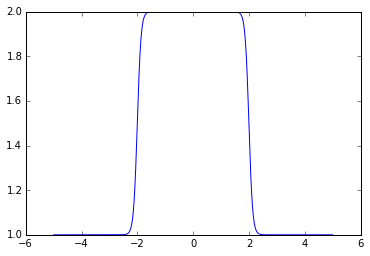

In [4]:
import math
x = np.linspace(-5, 5, 1000)

a1, a2 = 1, 1
b1, b2 = -15, 15
c1, c2 = -2, 2
def f1(x):
    return a1 / (1 + np.exp(b1*(x - c1)))
def f2(x):
    return a2 / (1 + np.exp(b2*(x - c2)))
fl1 = np.vectorize(f1)
fl2 = np.vectorize(f2)

y = (fl1(x) + fl2(x))
#y = .5 * fl1(x)
plt.plot(x, y)